## 04.5: Working With Vector Data Using `Geopandas`

In this notebook, we illustrate how to carry out some basic operations on geospatial data that is in the form of vector data. Vector data differs significantly from raster data, which is the format of geospatial data we've been working with so far. The easiest way to conceptualize vector data is as a table of data containing columns representing variables or fields, and rows that represent geographic records or "features." Importantly, those each geographic records or features can consist of only one fundamental data type – points, lines (or segments), or polygons. In GIS platforms like ArcGIS or QGIS, this table is what's known as the "attribute table" that you can open when you right click on a shapefile/layer/coverage in the data explorer window. Each of the geographic records is associated with information that defines the location of that record in space. For example, point records will be associated (or "related") with their x- and y-coordinates in the coordinate reference system of the dataset. Line records or segments will be associated with two vertices that have associated x- and y- coordinates, as well as the length or distance between those vertices. Finally, a polygon record will be associated with the vertices and lines that enclose the polygon, as well as the area encompassed by those line segments. Line segments of polygons are also a bit more complicated in that they also contain information about which side of the line segment the polygon is located as you would "navigate" from one vertext to the next in a defined direction along the exterior of the polygon. Most commonly, the line segments are navigated such that the polygon is always to the *_right_* of a line segment when moving clockwise from one line segment to the next. 

With this in mind, it becomes clear why we call GIS data a "relational database." The database (table of data) has records (rows) that relate to some geographic feature (a point, line, or polygon). We have already seen taht the `pandas` library is very powerful for dealing with tabular data (in our case in the form of time series, where every record consisted of one interval/point in time). The `geopandas` library is simply an extension of the `pandas` framework that then associates each record in a data table with some geographic feature. While not a powerful and comprehensive GIS platform, it does allow us some pretty helpful utilities for creating, editing, reading, and performing some basic geospatial operations – like reprojection, clipping, and buffering – in Python; without the computational overhead of a full GIS GUI. In the notebook below, we carry out a common workflow that a hydrologist might need to do. Specifically, we will use an existing watershed boundary dataset (a polygon dataset) to clip another dataset that contains the delineated river network (a line dataset) over a broader region. 

## 1. Imports and Definitions

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

nhd_file = '../data/NHD_H_1705_HU4_GPKG.gpkg' # Middle Snake (inc. Boise)
ws_file = '../data/ubrb/upper_boise_geometry.shp'

export_file = '../data/ubrb_hydrography.geojson'

epsg_utm = 32613

In [2]:
ws_gdf = gpd.read_file(ws_file)
ws_gdf

sourcedata  areaacres sourcefeat        shape_leng states sourceorig  \
0       None  486280.99       None  2.82926983182592     ID       None   
1       None  836097.52       None   4.3664242877153     ID       None   
2       None  397423.64       None  2.78095370323452     ID       None   

          shape_area      huc8 areasqkm                          name  \
0  0.220329659705026  17050111  1967.91  North and Middle Forks Boise   
1  0.376885299722635  17050113  3383.57              South Fork Boise   
2    0.1797845336911  17050112  1608.32                   Boise-Mores   

                                    tnmid metasource        loaddate gnis_id  \
0  {61B79CD3-38D5-441B-96FB-159A5D2D00B7}       None  20130118135515    None   
1  {CFE636CD-99A5-4D5C-B08A-6CA824951654}       None  20130118135515    None   
2  {C3D4B475-E628-4FA4-9287-17E51741B72E}       None  20130118135515    None   

                                            geometry  
0  POLYGON ((-115.73961 43.74613, -115.7396 43.74...  
1  POLYGON ((-115.93718 43.51423, -115.93718 43.5...  
2  POLYGON ((-116.10022 43.69616, -116.10022 43.6...

In [3]:
ws_gdf.explore()

In [4]:
gpd.list_layers(nhd_file)

/Users/lejoflores/GEOS-505-Fall2025/env/lib/python3.12/site-packages/pyogrio/core.py:130: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_list_layers(get_vsi_path_or_buffer(path_or_buffer))


name      geometry_type
0                   NHDArea     MultiPolygon Z
1            NHDAreaEventFC       MultiPolygon
2               NHDFlowline  MultiLineString Z
3                   NHDLine  MultiLineString Z
4            NHDLineEventFC    MultiLineString
5                  NHDPoint            Point Z
6           NHDPointEventFC              Point
7              NHDWaterbody     MultiPolygon Z
8                   WBDHU10       MultiPolygon
9                   WBDHU12       MultiPolygon
10                  WBDHU14       MultiPolygon
11                  WBDHU16       MultiPolygon
12                   WBDHU2       MultiPolygon
13                   WBDHU4       MultiPolygon
14                   WBDHU6       MultiPolygon
15                   WBDHU8       MultiPolygon
16                  WBDLine    MultiLineString
17        ExternalCrosswalk               None
18                 NHDFCode               None
19     NHDFeatureToMetadata               None
20                  NHDFlow               None
21           NHDFlowlineVAA               None
22              NHDMetadata               None
23  NHDProcessingParameters               None
24  NHDReachCodeMaintenance               None
25   NHDReachCrossReference               None
26        NHDSourceCitation               None
27                NHDStatus               None
28  NHDVerticalRelationship               None

In [5]:
nhd_gdf = gpd.read_file(nhd_file, layer='NHDFlowline')
nhd_gdf

/Users/lejoflores/GEOS-505-Fall2025/env/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(


permanent_identifier                     fdate  resolution   gnis_id  \
0                 131371650 2012-02-21 21:58:09+00:00           2  01128885   
1                 131371481 2012-02-21 21:59:28+00:00           2  01128885   
2                 131362970 2012-02-21 22:00:14+00:00           2      None   
3                 131369519 2012-02-21 22:00:14+00:00           2  01125528   
4                 131368883 2012-02-21 22:00:14+00:00           2      None   
...                     ...                       ...         ...       ...   
178761            131362913 2012-02-21 22:00:14+00:00           2      None   
178762            131361243 2012-02-21 21:57:33+00:00           2  01125528   
178763            165179119 2012-02-21 22:00:14+00:00           2      None   
178764            165179122 2012-02-21 21:58:44+00:00           2      None   
178765            165178996 2012-02-21 21:57:33+00:00           2      None   

                       gnis_name  lengthkm       reachcode  flowdir  \
0       West Little Owyhee River     0.631  17050107000199        1   
1       West Little Owyhee River     0.922  17050107000171        1   
2                           None     3.085  17050107001900        1   
3                     Pole Creek     0.328  17050107004176        1   
4                           None     1.857  17050107003953        1   
...                          ...       ...             ...      ...   
178761                      None     0.719  17050107001881        1   
178762                Pole Creek     1.796  17050107001365        1   
178763                      None     1.047  17050107002297        1   
178764                      None     1.275  17050107000917        1   
178765                      None     1.225  17050107004184        1   

       wbarea_permanent_identifier  ftype  ...  visibilityfilter  \
0                             None    460  ...           5000000   
1                             None    460  ...           5000000   
2                             None    460  ...            100000   
3                             None    460  ...            100000   
4                             None    460  ...             50000   
...                            ...    ...  ...               ...   
178761                        None    460  ...             50000   
178762                        None    460  ...            500000   
178763                        None    460  ...             50000   
178764                        None    460  ...            100000   
178765                        None    460  ...             50000   

        SHAPE_Length  Enabled  resolution_description  flowdir_description  \
0           0.006329        1                    High        WithDigitized   
1           0.009306        1                    High        WithDigitized   
2           0.034796        1                    High        WithDigitized   
3           0.003850        1                    High        WithDigitized   
4           0.020510        1                    High        WithDigitized   
...              ...      ...                     ...                  ...   
178761      0.007042        1                    High        WithDigitized   
178762      0.019701        1                    High        WithDigitized   
178763      0.010254        1                    High        WithDigitized   
178764      0.015242        1                    High        WithDigitized   
178765      0.013264        1                    High        WithDigitized   

        mainpath_description innetwork_description  \
0                Unspecified                   Yes   
1                Unspecified                   Yes   
2                Unspecified                   Yes   
3                Unspecified                   Yes   
4                Unspecified                   Yes   
...                      ...                   ...   
178761           Unspecified                   Yes   
178762           Un

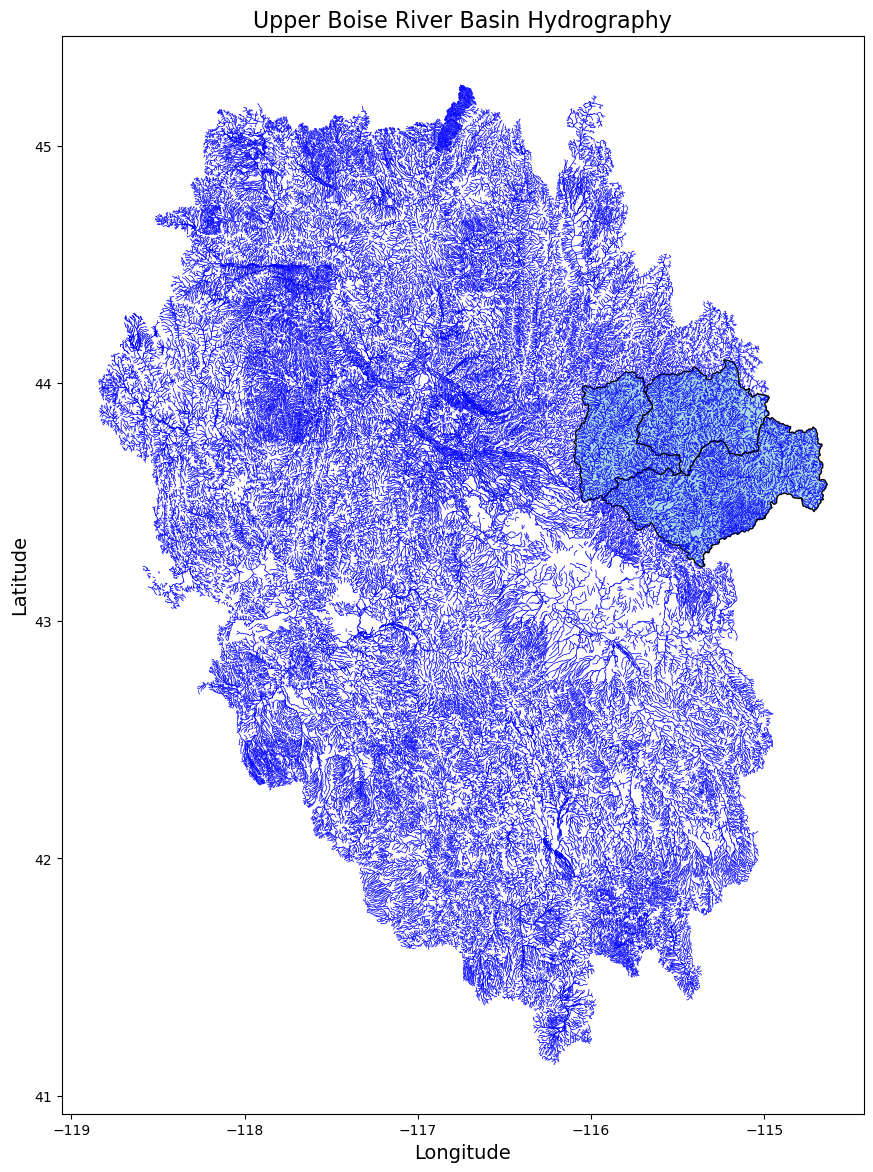

In [6]:
fig, ax = plt.subplots(figsize=(14,14))
ws_gdf.plot(color='lightblue', edgecolor='black', ax=ax)
nhd_gdf.plot(color='blue', linewidth=0.5, ax=ax)
ax.set_title('Upper Boise River Basin Hydrography', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.show()

In [7]:
ws_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
nhd_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [9]:
ws_utm_gdf = ws_gdf.to_crs(epsg=epsg_utm)
ws_utm_gdf.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
nhd_utm_gdf = nhd_gdf.to_crs(epsg=epsg_utm)
nhd_utm_gdf.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
nhd_clipped_gdf = gpd.clip(nhd_utm_gdf, ws_utm_gdf)
nhd_clipped_gdf

permanent_identifier                     fdate  resolution   gnis_id  \
3288               55020871 2012-01-21 22:05:01+00:00           2      None   
41658              55020843 2012-01-21 22:05:01+00:00           2      None   
11952              55020817 2012-01-21 22:05:00+00:00           2      None   
50663              55020749 2012-01-21 22:05:00+00:00           2      None   
33181              55020693 2012-01-21 22:04:59+00:00           2      None   
...                     ...                       ...         ...       ...   
149525             52470630 2012-01-21 21:30:12+00:00           2      None   
2855               52470615 2012-01-21 21:30:12+00:00           2      None   
168841             52470583 2012-01-21 21:30:12+00:00           2  00399902   
6394               52470591 2012-01-21 21:30:12+00:00           2  00399902   
147736             52470577 2012-01-21 21:30:12+00:00           2  00399902   

           gnis_name  lengthkm       reachcode  flowdir  \
3288            None     0.494  17050113350593        1   
41658           None     0.932  17050113350585        1   
11952           None     1.565  17050113001296        1   
50663           None     0.699  17050113350562        1   
33181           None     0.371  17050113350549        1   
...              ...       ...             ...      ...   
149525          None     1.531  17050112000186        1   
2855            None     1.332  17050112098606        1   
168841  Grimes Creek     0.690  17050112000144        1   
6394    Grimes Creek     0.742  17050112000145        1   
147736  Grimes Creek     1.665  17050112000144        1   

       wbarea_permanent_identifier  ftype  ...  visibilityfilter  \
3288                          None    460  ...             24000   
41658                         None    460  ...             24000   
11952                         None    460  ...             24000   
50663                         None    460  ...             24000   
33181                         None    460  ...            100000   
...                            ...    ...  ...               ...   
149525                        None    460  ...             24000   
2855                          None    460  ...             24000   
168841                        None    460  ...           5000000   
6394                          None    460  ...           2000000   
147736                        None    460  ...           5000000   

        SHAPE_Length  Enabled  resolution_description  flowdir_description  \
3288        0.005588        1                    High        WithDigitized   
41658       0.009987        1                    High        WithDigitized   
11952       0.018053        1                    High        WithDigitized   
50663       0.007269        1                    High        WithDigitized   
33181       0.003472        1                    High        WithDigitized   
...              ...      ...                     ...                  ...   
149525      0.014394        1                    High        WithDigitized   
2855        0.013832        1                    High        WithDigitized   
168841      0.007325        1                    High        WithDigitized   
6394        0.008751        1                    High        WithDigitized   
147736      0.020092        1                    High        WithDigitized   

        mainpath_description innetwork_description  \
3288             Unspecified                   Yes   
41658            Unspecified                   Yes   
11952            Unspecified                   Yes   
50663            Unspecified                   Yes   
33181            Unspecified                   Yes   
...                      ...                   ...   
149525           Unspecified                   Yes   
2855             Unspecified                   Yes   
168841           Unspecified                   Yes   
6394             Unspecified                   Yes   
1

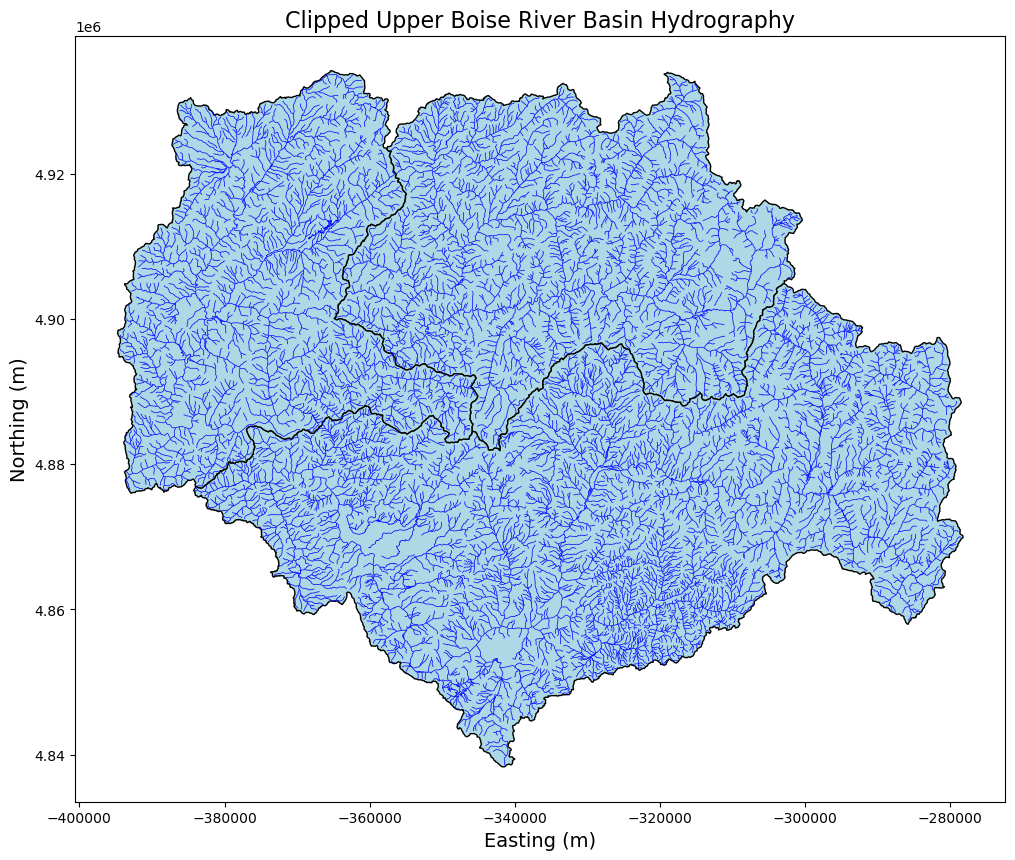

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
ws_utm_gdf.plot(color='lightblue', edgecolor='black', ax=ax)
nhd_clipped_gdf.plot(color='blue', linewidth=0.5, ax=ax)
ax.set_title('Clipped Upper Boise River Basin Hydrography', fontsize=16)
ax.set_xlabel('Easting (m)', fontsize=14)
ax.set_ylabel('Northing (m)', fontsize=14)
plt.show()

In [13]:
if os.path.exists(export_file):
        os.remove(export_file) # Delete the existing file

nhd_clipped_gdf.to_file(export_file, driver='geoJSON')